# 전이학습용 데이터셋 준비

- [한국인 감정인식을 위한 복합 영상 데이터](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=82)는 데이터는 많으나, 클래스 별로 사진 분류가 완벽하게 되어 있지 않은 문제가 있음. (기쁨 카테고리에 놀란 표정이 있는 등)
- 위 데이터셋에는 수 만 장의 사진 데이터가 있는데, 정확도가 더 높은 ResNet18 등을 이용해 전이학습을 하는 경우 그 정도로 많은 데이터를 준비하지 않아도 됨.
- [01.learning.ipynb](./01.learning.ipynb)에서 FER2013 데이터로 학습한 ResNet9 모델을 활용하여 한국인 영상 데이터를 클래스 별로 300장 정도로 추리고 그 결과에 대해서만 수동으로 확인하면 시간을 줄이면서도 학습 데이터의 일관성을 확보할 수 있을 것으로 기대.


In [1]:
import glob
import os
import random
import shutil

import cv2
import matplotlib.pyplot as plt
import torch
from ai import get_default_device, predict, to_device
from PIL import Image
from resnet9 import ResNet9
from tqdm.notebook import tqdm

In [2]:
DATA_PATH = "./data/img/train"
OUT_PATH = "./data/ResNet18"

In [3]:
img_path_list = glob.glob(os.path.join(DATA_PATH, "**/*.jpg"))
img_path_list[:3]

['./data/img/train/상처/6be9be83ef9bbbfa545d62b5758cb7a3eebb82712bf9e1e7798938bafbaf8f5d_┐й_20_╗є├│_╜╟┐▄ └┌┐м╚п░ц_20210119150836-007-004_face.jpg',
 './data/img/train/상처/1b70d9519cc7a82634ccd0bf44ccdb2412279ba909d2d1759c87e3794ad0af12_┐й_20_╗є├│_╡╡╜╔ ╚п░ц_20201207032203-008-002_face.jpg',
 './data/img/train/상처/6a44de2e514d08e712dffc46e8133298af75b80668546e781bcee97fa777ca0e_│▓_20_╗є├│_╣о╚н└ч ╣╫ └п└√┴Ў_20201205170132-009-009_face.jpg']

In [4]:
device = get_default_device()
device

device(type='cuda')

### 모델

- ResNet9


In [5]:
MODEL_PATH = "./models/ResNet9/ResNet9_epoch-198_score-0.846.pth"

model = to_device(ResNet9(1, 7), device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

print(MODEL_PATH)

./models/ResNet9/ResNet9_epoch-198_score-0.846.pth


  0%|          | 0/48511 [00:00<?, ?it/s]

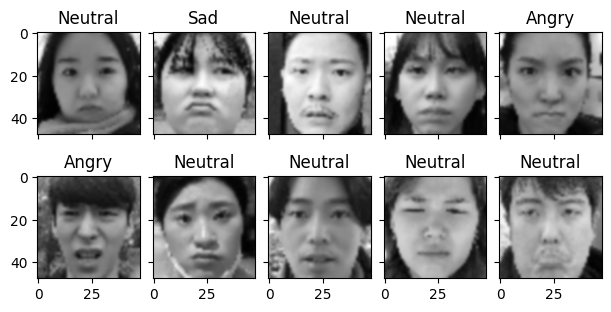

In [6]:
img_categories = {}

fig, axes = plt.subplots(
    2, 5, figsize=(6, 3), sharex=True, sharey=True, constrained_layout=True
)

for idx, img_path in tqdm(enumerate(img_path_list), total=len(img_path_list)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, dsize=(48, 48))

    emotion = predict(Image.fromarray(img), model, device)
    if emotion not in img_categories:
        img_categories[emotion] = []
    img_categories[emotion].append(img_path)

    if idx < 10:
        q, r = divmod(idx, 5)
        axes[q][r].imshow(img, cmap="gray", interpolation="bicubic")
        axes[q][r].set_title(emotion)

plt.show()
plt.close(fig)

In [7]:
# 랜덤이지만 매번 다르지 않게 시드 설정
random.seed(47)


def copy_samples(n: int, key: str, kind: str):
    # 학습에 사용할 k장 뽑기

    train_set = random.sample(v, k=n)

    # 복사할 경로
    train_out_path = os.path.join(OUT_PATH, kind, key)
    os.makedirs(train_out_path, exist_ok=True)

    for src in train_set:
        # 복사 대상 경로에서 '기쁨' 같은 원래 레이블 제거
        dest = src.replace(DATA_PATH, "")
        dest = os.path.join(train_out_path, *dest.split("/")[2:])
        shutil.copyfile(src, dest)


for k, v in img_categories.items():
    # Training 샘플
    copy_samples(200, k, "train")

    # Validation 샘플
    copy_samples(30, k, "val")